## Batch Processing in openEO

### Introduction

In many geospatial analysis tasks, you need flexibility in how data is processed, especially when working with large datasets. While OpenEO lets you process data on powerful backend servers, you have options for how and when to retrieve the results. OpenEO supports both synchronous and asynchronous execution, allowing you to choose between running processes interactively or submitting them as batch jobs to the backend.

- **Synchronous Execution**: With synchronous commands like `execute` or `download`, OpenEO performs the computation on the backend, and you wait until the result is ready to use. While this approach is effective for smaller tasks, it requires your session to remain active until completion.

- **Batch Jobs (Asynchronous Execution)**: OpenEO also allows you to submit processes as asynchronous jobs. The same process graph you would use for interactive execution can be sent to the backend as a *job*. Once submitted, you can choose to wait for completion or disconnect and check back later. You can even configure the job to notify you by email when processing finishes, providing flexibility for tasks that require significant time or resources.

### Why Batch Processing?

Batch processing is advantageous for larger, more complex calculations where waiting is impractical. By sending a job to the backend, you allow the process to run independently of your active session, freeing you up for other tasks. Additionally, OpenEO makes it easy to rerun jobs without recreating the process graph, supporting reproducibility and analysis consistency. With batch processing, OpenEO also enables on-demand web services, allowing you to trigger computations through HTTP requests that return the result when completed.

### Objective

This tutorial will guide you through the differences between synchronous and asynchronous processing in OpenEO, highlighting the strengths of batch processing for large-scale analysis. We’ll demonstrate how to submit a process graph as a job and monitor its status, showing how OpenEO simplifies long-running computations.

### In this notebook, you will explore the following concepts:

- **Synchronous vs. Asynchronous Execution**: Learn the differences between using `execute`/`download` and submitting batch jobs.
- **Job Management**: Understand how to submit, monitor, and retrieve results from a batch job, allowing you to optimize workflows for long-running tasks.
- **Web Services for Batch Jobs**: Explore how OpenEO supports web services, enabling you to request processing via HTTP, making results accessible with flexible parameters. <span style="color: goldenrod;">(FUTURE FEATURE)</span>

### Tools You'll Use:

- **openEO**: To build process graphs, execute them synchronously, or submit them as asynchronous jobs.
- **Backend Notifications**: Optionally configure email alerts for completed jobs.

### Learning Outcomes

By the end of this tutorial, you will be able to:

- Choose between synchronous and asynchronous execution in OpenEO.
- Submit and monitor batch jobs, retrieving results only when ready.
- Set up web services for automated result retrieval based on your process graph. <span style="color: goldenrod;">(FUTURE FEATURE)</span>

Using OpenEO’s batch processing capabilities, you can tackle complex analyses without being tied to your session, allowing you to efficiently utilize backend resources.


## Theory Behind Batch Processing in openEO

### Synchronous Execution: Immediate Results for Prototyping

OpenEO provides two main methods for synchronous execution: `execute` and `download`. Both options run your process on backend servers, handling all computation remotely, but they differ in how they return results:

- **`execute`**:
  - Runs the process graph and returns only the metadata or a lightweight summary, without transferring large data. This method is ideal for validating your process or checking structure without downloading extensive datasets.
  
- **`download`**:
  - Runs the full process and transfers the resulting dataset to your local environment, useful when you need the complete output for further local analysis or visualization.

With synchronous execution, you can test on smaller areas or shorter time spans, which is effective for interactive prototyping and intermediate validation.

### Asynchronous Execution: Submitting Production Jobs

Once your process graph is fully refined, OpenEO allows you to switch to asynchronous batch processing for a comprehensive run. Submitting the process graph as a batch job provides several benefits:

1. **Production-Ready Output**:
   - When you submit the job, OpenEO’s backend can process the entire time span or larger areas, efficiently producing your final output without needing you to stay connected.

2. **Job Management & Notifications**:
   - You can request notifications (e.g., by email) when the job completes, so you don’t need to monitor it directly.

3. **Reusability**:
   - Completed jobs can be rerun as needed. This is efficient for recalculating results with similar or updated data.

4. **On-Demand Services**:
   - OpenEO supports converting your job into a web service, allowing requests with parameters like time ranges or regions directly via HTTPS, ideal for automated and on-demand analysis.

### Efficient Workflow: From Prototype to Production

Using OpenEO, you can build your analysis step-by-step in a notebook, experimenting with intermediate outputs on smaller data. When ready, submitting a job for full-scale analysis allows OpenEO to handle the heavy processing. This prototyping-to-production approach lets you efficiently progress from concept to final result with confidence in each stage of development.


In [1]:
import openeo
from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2

# a. connect to the openeo back-end
conn = openeo.connect(eo_service_url)
conn.authenticate_basic(username= user, password=passwd)


<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

## Revisiting Syncronous Execution
Let's revisit the NDVI processing we did in a previous exercise. As you remember, 
we created a process that loaded a collection and applied the pre-baked NDVI process 
to it and then  we used the syncronous `download` alternative to perform the actual execution in our back-end and then downloaded and showed the result. 
We will now first run this process as before to see what to expect when we submit the same process as batch job:

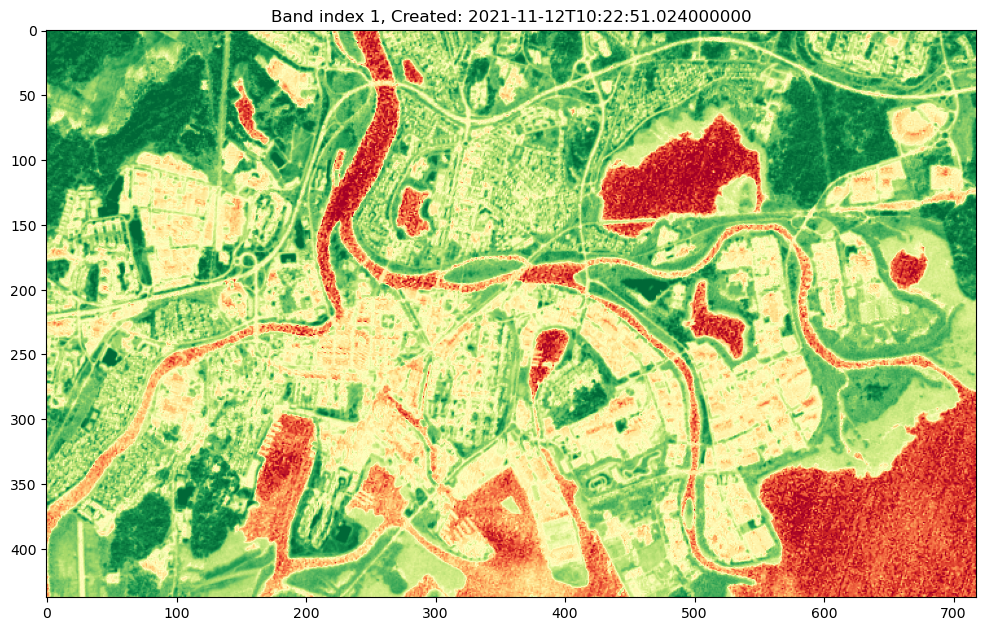

In [2]:
# B. Loading the data
cube=conn.load_collection(s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.one_image,
                         bands=['b04','b08'])
# C.Building and Executing the NDVI Process
ndvi =cube.ndvi(nir="b08",red="b04")
res = ndvi.download(format="gtiff")
# D. Visulizing the result
display(ndvi)
_ = show_result(res,is_ndvi=True)

## Creating and Submitting the NDVI Process as a Batch Job

Instead of running the NDVI process synchronously, we can create a batch job that submits the process to the backend, allowing us to handle larger or longer-running tasks asynchronously. Here, we'll use `ndvi.create_job()` to create the job, then start it and wait for completion. Firstly, we will start the job and wait for completion. This is actually no difference to the previous syncronous executions, but you are allowed to execute larger jobs this way.


In [3]:
# Creating a batch job for the NDVI process defined in previous cell
job = ndvi.create_job(out_format="GTiff", title="NDVI Batch Job", description="Calculating NDVI for selected area")

job

<BatchJob job_id='804aef5c-dc10-4c6a-b184-d5dced9d8ca3'>

In [4]:
job.start_and_wait()

0:00:00 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': send 'start'
0:00:00 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': queued (progress 0.0%)
0:00:05 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': running (progress 0.0%)
0:00:11 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': finished (progress 0.0%)


<BatchJob job_id='804aef5c-dc10-4c6a-b184-d5dced9d8ca3'>

In [5]:
# Examining the results
res = job.get_results()
res

<JobResults for job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3'>

In [6]:
job.logs()

[{'id': '57',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-drmh2 Received Job for execution.',
  'time': '2024-10-16T09:20:27.744327Z'},
 {'id': '58',
  'level': 'info',
  'message': 'Mailed results to None.',
  'time': '2024-10-16T09:20:36.809898Z'},
 {'id': '59',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-drmh2 Completed Job with State.finished.',
  'time': '2024-10-16T09:20:36.820324Z',
  'usage': {'duration': {'value': 9037.0, 'unit': 'ms'}}}]

In [7]:
# We can even run the job again
job.start_and_wait()
job.logs()

0:00:00 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': send 'start'
0:00:00 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': queued (progress 0.0%)
0:00:05 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': running (progress 0.0%)
0:00:11 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': running (progress 0.0%)
0:00:19 Job '804aef5c-dc10-4c6a-b184-d5dced9d8ca3': finished (progress 0.0%)


[{'id': '57',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-drmh2 Received Job for execution.',
  'time': '2024-10-16T09:20:27.744327Z'},
 {'id': '58',
  'level': 'info',
  'message': 'Mailed results to None.',
  'time': '2024-10-16T09:20:36.809898Z'},
 {'id': '59',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-drmh2 Completed Job with State.finished.',
  'time': '2024-10-16T09:20:36.820324Z',
  'usage': {'duration': {'value': 9037.0, 'unit': 'ms'}}},
 {'id': '60',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-lbkrf Received Job for execution.',
  'time': '2024-10-16T09:20:41.887676Z'},
 {'id': '61',
  'level': 'info',
  'message': 'Worker EOW-9711-worker-7b7c897b45-lbkrf Completed Job with State.finished.',
  'time': '2024-10-16T09:20:50.923978Z',
  'usage': {'duration': {'value': 8993.0, 'unit': 'ms'}}}]

# Working with the results
Either you click on above links or you can use `get_assets()` to do this programatically

In [8]:
display(res.get_assets())
print()
data = None
for asset in res.get_assets():
    print("NAME:    ",asset.name)
    print("HREF:    ",asset.href)
    print("METADATA:",asset.metadata)
    if asset.metadata['type']=='image/tiff; application=geotiff':
        data = asset.load_bytes()
    print()

[<ResultAsset 'process.json' (type application/json) at 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/process.json?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=5MxfFrrcOYjGUcyi%2BVZ5JPht%2FxE%3D&Expires=1729074038'>,
 <ResultAsset 'out_2021_11_12T10_22_51.tif' (type image/tiff; application=geotiff) at 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/out_2021_11_12T10_22_51.tif?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=Vs39HuifnEOtxUt12KeqlGeXGQ8%3D&Expires=1729074038'>,
 <ResultAsset 'stac.json' (type application/json) at 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/stac.json?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=ns7zdwKYVgA4WyzEA9Ic1XSPAK0%3D&Expires=1729074038'>,
 <ResultAsset '804aef5c-dc10-4c6a-b184-d5dced9d8ca3.txt' (type application/yml) at 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc


NAME:     process.json
HREF:     https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/process.json?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=5MxfFrrcOYjGUcyi%2BVZ5JPht%2FxE%3D&Expires=1729074038
METADATA: {'type': 'application/json', 'title': 'process.json', 'roles': ['process', 'reproduction'], 'href': 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/process.json?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=5MxfFrrcOYjGUcyi%2BVZ5JPht%2FxE%3D&Expires=1729074038'}

NAME:     out_2021_11_12T10_22_51.tif
HREF:     https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6a-b184-d5dced9d8ca3/out_2021_11_12T10_22_51.tif?AWSAccessKeyId=404f289445e14c4096da2a011c9a94ba&Signature=Vs39HuifnEOtxUt12KeqlGeXGQ8%3D&Expires=1729074038
METADATA: {'type': 'image/tiff; application=geotiff', 'roles': ['data'], 'href': 'https://s3.rise.safedc.net/userdata/testuser_0/jobs/804aef5c-dc10-4c6

As you can see above, we loaded the image result into the variable `data`. Obviously, if we had more than one image in our response, `data`would be overwritten in the loop but i hope you get the message here. And as you can see below, we got the very same data as we got before


[<open DatasetReader name='/vsipythonfilelike/788c2acd-d447-4c34-a10a-70f33f6f6717/788c2acd-d447-4c34-a10a-70f33f6f6717' mode='r'>]

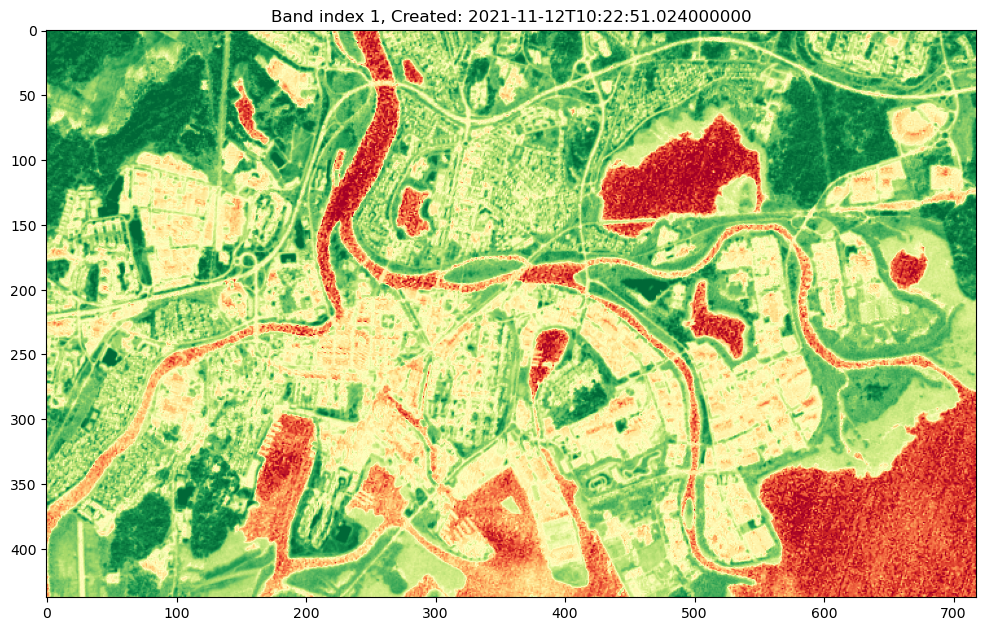

In [9]:
show_result(data,is_ndvi=True)